In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import my_get_cmap, rank_int

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
exclude_str = 't1Exclude'
extra_str = '_consist' # '_vol_norm' '_noboxcox' '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_scale = 200
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight)

### Setup output directory

In [4]:
print(os.environ['TRTEDIR'])
if not os.path.exists(os.environ['TRTEDIR']): os.makedirs(os.environ['TRTEDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis_int/t1Exclude


# Load in metadata

In [5]:
# LTN and Health Status
health = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/health/n1601_health_20170421.csv'))
# Protocol
prot = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/n1601_pnc_protocol_validation_params_status_20161220.csv'))
# T1 QA
t1_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_t1QaData_20170306.csv'))
# DTI QA
dti_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/dti/n1601_dti_qa_20170301.csv'))
# Rest QA
rest_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/rest/n1601_RestQAData_20170714.csv'))
# Demographics
demog = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/demographics/n1601_demographics_go1_20161212.csv'))
# Brain volume
brain_vol = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_ctVol20170412.csv'))

# GOASSESS Bifactor scores
goassess = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'GO1_clinical_factor_scores_psychosis_split_BIFACTOR.csv'))
# cnb
cnb = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/cnb/n1601_cnb_factor_scores_tymoore_20151006.csv'))

# merge
df = health
df = pd.merge(df, prot, on=['scanid', 'bblid']) # prot
df = pd.merge(df, t1_qa, on=['scanid', 'bblid']) # t1_qa
df = pd.merge(df, dti_qa, on=['scanid', 'bblid']) # dti_qa
df = pd.merge(df, rest_qa, on=['scanid', 'bblid']) # rest_qa
df = pd.merge(df, demog, on=['scanid', 'bblid']) # demog
df = pd.merge(df, brain_vol, on=['scanid', 'bblid']) # brain_vol

df = pd.merge(df, goassess, on=['bblid']) # goassess
df = pd.merge(df, cnb, on=['scanid', 'bblid']) # brain_vol

print(df.shape[0])
df.set_index(['bblid', 'scanid'], inplace = True)

1599


In [6]:
df.head()

,,timepoint_x,smrytrt_psychinpt,psychoactiveMedPsychv2,psychoactiveMedMedicalv2,incidentalFindingExclude,medicalratingExcludev1,healthExcludev2,ltnExcludev2,squeakycleanExclude,psychoactiveMedMedical,...,F1_Exec_Comp_Cog_Accuracy_Ar,F2_Social_Cog_Accuracy_Ar,F3_Memory_Accuracy_Ar,F1_Social_Cognition_Efficiency_Ar,F2_Complex_Reasoning_Efficiency_Ar,F3_Memory_Efficiency_Ar,F4_Executive_Efficiency_Ar,F1_Slow_Speed_Ar,F2_Memory_Speed_Ar,F3_Fast_Speed_Ar
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
80961,2632,1,0,1,0,0,0,0,1,1,0,...,-1.147680,-0.985732,0.103675,-0.248342,-1.500726,0.749361,0.276936,0.012737,0.673015,0.927039
80199,2637,1,0,0,0,0,0,0,0,0,0,...,-0.262102,0.951817,-0.729813,1.309180,0.323467,-0.216490,-0.439120,0.882288,0.621913,-0.233789
80179,2643,1,1,1,0,0,0,0,1,1,0,...,-2.456514,-3.463454,-2.023924,-2.082903,-0.919736,-0.722441,-1.598467,1.000161,0.009006,-0.118194
81005,2644,1,0,0,0,0,1,1,1,1,0,...,1.164884,1.348419,0.936387,0.899698,1.231159,1.485604,0.195561,-0.180368,1.025021,0.518658
80812,2646,1,0,0,0,0,0,0,0,1,0,...,0.454563,0.892760,0.400804,1.000376,1.442359,0.554244,0.390312,0.891195,0.657851,0.582442


# Filter subjects

In [7]:
# 1) Primary sample filter
df = df[df['healthExcludev2'] == 0]
print('N after initial exclusion:', df.shape[0])

# 2) T1 exclusion
df = df[df[exclude_str] == 0]
print('N after T1 exclusion:', df.shape[0])

# 3) Diffusion exclusion
df = df[df['b0ProtocolValidationStatus'] == 1]
df = df[df['dti64ProtocolValidationStatus'] == 1]
df = df[df['dti64Exclude'] == 0]
print('N after Diffusion exclusion:', df.shape[0])

N after initial exclusion: 1445
N after T1 exclusion: 1394
N after Diffusion exclusion: 1100


In [8]:
df['dti64QAManualScore'].unique()

array([2., 1.])

In [9]:
np.sum(df['dti64QAManualScore'] == 2)

675

In [10]:
# Convert age to years
df['ageAtScan1_Years'] = np.round(df.ageAtScan1/12, decimals=1)

In [11]:
# find unique ages
age_unique = np.unique(df.ageAtScan1_Years)
print('There are', age_unique.shape[0], 'unique age points')

There are 144 unique age points


## Normalize

In [12]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
          'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
          'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency']
print(phenos)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear', 'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency', 'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency']


In [13]:
for pheno in phenos:
    if df.loc[:,pheno].isna().any():
        print('NaN replacement: ', pheno)
        x = np.nanmedian(df.loc[:,pheno])
        df.loc[df.loc[:,pheno].isna(),pheno] = x

NaN replacement:  F1_Exec_Comp_Res_Accuracy
NaN replacement:  F2_Social_Cog_Accuracy
NaN replacement:  F3_Memory_Accuracy
NaN replacement:  F1_Complex_Reasoning_Efficiency
NaN replacement:  F2_Memory.Efficiency
NaN replacement:  F3_Executive_Efficiency
NaN replacement:  F4_Social_Cognition_Efficiency


In [14]:
rank_r = np.zeros(len(phenos),)

for i, pheno in enumerate(phenos):
    # normalize regional metric
#     x = sp.stats.yeojohnson(df.loc[:,pheno])[0]
    x = rank_int(df.loc[:,pheno])
    # check if rank order is preserved
    rank_r[i] = sp.stats.spearmanr(df.loc[:,pheno],x)[0]
    # store normalized version
    df.loc[:,pheno] = x

print(np.sum(rank_r < 1))

0


In [15]:
df.loc[:,phenos].var()

Overall_Psychopathology            0.984011
Psychosis_Positive                 0.997019
Psychosis_NegativeDisorg           0.997019
AnxiousMisery                      0.997019
Externalizing                      0.997015
Fear                               0.997012
F1_Exec_Comp_Res_Accuracy          0.997028
F2_Social_Cog_Accuracy             0.997028
F3_Memory_Accuracy                 0.997028
F1_Complex_Reasoning_Efficiency    0.997028
F2_Memory.Efficiency               0.997028
F3_Executive_Efficiency            0.997028
F4_Social_Cognition_Efficiency     0.997028
dtype: float64

## Export

In [16]:
header = ['ageAtScan1', 'ageAtScan1_Years','sex','race2','handednessv2', 'restProtocolValidationStatus', 'restExclude',
          'dti64MeanAbsRMS','dti64MeanRelRMS','dti64MaxAbsRMS','dti64MaxRelRMS','mprage_antsCT_vol_TBV', 'averageManualRating',
          'Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
          'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
          'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency']
df.to_csv(os.path.join(os.environ['TRTEDIR'], 'df_pheno.csv'), columns = header)

# Plots

In [17]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

labels = ['Train', 'Test']
phenos_label_short = ('Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear')
phenos_label = ('Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear')

## Age

In [18]:
df['sex'].unique()

array([2, 1])

In [19]:
(np.sum(df.loc[:,'sex'] == 1)/df.shape[0]) * 100

46.0

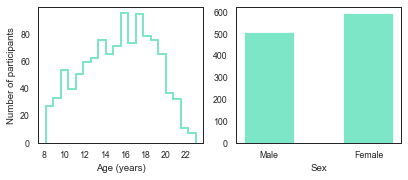

In [20]:
f, axes = plt.subplots(1,2)
f.set_figwidth(6.5)
f.set_figheight(2.5)
colormap = sns.color_palette("pastel", 2)

sns.distplot(df.loc[:,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[1],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[0]), ax = axes[0]);
axes[0].set_xlabel('Age (years)');
axes[0].set_ylabel('Number of participants');
axes[0].set_xticks(np.arange(np.min(np.round(age_unique,0)), np.max(np.round(age_unique,0)), 2))

# set width of bar
barWidth = 0.25

# Sex
y_train = [np.sum(df.loc[:,'sex'] == 1), np.sum(df.loc[:,'sex'] == 2)]
r1 = np.arange(len(y_train))+barWidth/2
r2 = [x + barWidth for x in r1]
axes[1].bar([0,0.5], y_train, width = barWidth, color = cmap[0])
axes[1].set_xlabel('Sex')
# axes[1].set_ylabel('Number of participants')
axes[1].set_xticks([0,0.5])
axes[1].set_xticklabels(['Male', 'Female'])

f.savefig('age_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Phenotype distributions over train/test

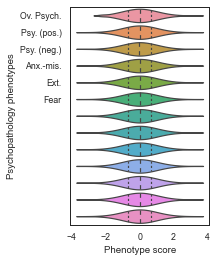

In [21]:
df_rc = pd.melt(df, value_vars = phenos)

f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(4)
ax = sns.violinplot(y='variable', x='value', data=df_rc, split=True, scale='width', inner = 'quartile', orient = 'h')
# ax.get_legend().remove()
ax.set_yticklabels(phenos_label_short)
ax.set_ylabel('Psychopathology phenotypes')
ax.set_xlabel('Phenotype score')
f.savefig('phenos_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

### Export sample for FC gradients

In [22]:
# 4) rs-fMRI exclusion
df = df[df['restProtocolValidationStatus'] == 1]
df = df[df['restExclude'] == 0]
print('N after rs-fMRI exclusion:', df.shape[0])

N after rs-fMRI exclusion: 926


In [23]:
df.to_csv(os.path.join(os.environ['TRTEDIR'], 'df_gradients.csv'), columns = header)